![title](UCN.png)

 #  <font color=blue> Optimización con Python & Cplex - Transbordo </font>

<div class="alert alert-info"> </h4> Material preparado para la carrera de Ingeniería Civil Industrial | Universidad Católica del Norte | Campus Coquimbo | Curso - Cadena de Suministros.                 
© Sergio Correa Santis, Ingenerio Industrial UCN, Master of International Business UQ, Master Engeneering of Supply Chain and Logistics, MIT ZLC-Global Scale.                               Contacto: sergio.correa@ucn.cl o sergio.correa.santis@gmail.com
</h4> </div>

## Modelo de Tranbordo

El modelo de transbordo es un caso especial del modelo de transporte, multifase, donde el flujo de materias primas y servicios es interrumpido en al menos un nodo entre el origen y el destino. En su construcción estándar el stock de productos de cada fabrica es enviado a uno de los centros de distribución (DC) y luego este a cualquiera de las tiendas.

<img src="transbordo.png" width="400" height="400" />

Si bien no es el objetivo de este manual determinar si la idea de utilizar centros de distribución o centros logísticos es correcta o no, es importante destacar que este tipo de diseño de red es bastante utilizado ya que brinda algunas ventas, en relación a amortiguar demanda y consolidar ordenes pequeñas, un ejemplo claro de esto son los cross-docking.

El problema general se representa en la red de la figura anterior. Hay **n Farbicas**, **k  DC** y **m Tiendas**, cada fuente y cada destino están representados por un nodo. **Los arcos representan las rutas que enlazan las fuentes y los destinos**. El arco (i, k) que une a la fuente i con el destino k conduce dos clases de información: el costo de transporte $c_{ik}$ por unidad por distancia, y la cantidad transportada $x_{ik}$. La capacidad de **oferta en la fuente i es $s_i$** y la **cantidad de demanda en el destino j es $d_j$**. El objetivo del modelo es determinar las incógnitas **$x_{ij}$** que **minimicen el costo total de transporte**, y que al mismo tiempo satisfagan las restricciones de oferta y demanda.


### El Modelo de Programación Lineal

$Min \; Z= \; \displaystyle\sum_{i=1}^{n}\sum_{j=1}^{m} x_{ij}c_{ij}$

$\displaystyle\sum_{k=1}^{k}x_{ik}\leq s_i$     $\; \; \forall \;i \; \in \; n$

$\displaystyle\sum_{k=1}^{k}x_{kj}\geq d_j$     $\; \; \forall \;j \; \in \; m$

$\displaystyle\sum_{i=1}^{n}x_{ik}- \displaystyle\sum_{j=1}^{m}x_{ki}=0$     $\; \; \forall \;k \; \in \; k$


**La última restricción** es conocida como la **conservación del flujo**, que indica que todo lo que entra al centro de distribución 1 provenientes de todas las plantas, debe ser igual a todo lo que sale del centro de distribución 1 hacia todas las tiendas. 

### El probelma
Dado que ya conocemos la concepción y la naturaleza del modelo, en este problema seremos más abstractos. El problema es minimizar el costo de transporte desde 2 Fabricas, con 2 Centros de Distribución a 3 Tiendas. Los datos están en las siguientes tablas: 


#### Capacidad de Producción  por Plantas ($s_i$)

|Producción|Planta 0|Planta 1|
|----------|--------|--------|
|          |10.000  |12.000  | 

#### Demanda de por Tienda ($d_i$)

| Demanda|Tienda 0|Tienda 1|Tienda 2|
|--------|--------|--------|--------|
|        |10.000  |7.000   |5.000   | 

#### Costo de Transporte desde DC a Tienda ($c_{kj}$)

| costo/unidad||Tienda 0|Tienda 1|Tienda 2|
|-------------|---------|--------|--------|
|DC 0         |2.350    |3.200   |2.150   | 
|DC 1         |2.850    |2.950   |2.200   | 

#### Costo de Transporte desde Fabrica a DC ($c_{ik}$)

| costo/unidad|DC 0  |DC1   |
|-------------|------|------|
|Fabrica 0    |3.000 |3.500 |
|Fabrica 1    |3.500 |3.200 |



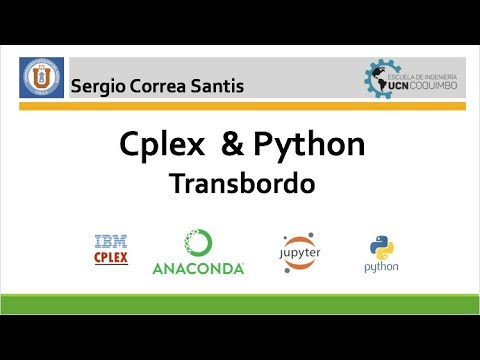

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('iUTkVnL2fd0')

# Paso 1: Datos

In [2]:
fabricas=[i for i in range(2)]
print(fabricas)

dc=[k for k in range(2)]
print(dc)

tiendas=[j for j in range(3)]
print(tiendas)

[0, 1]
[0, 1]
[0, 1, 2]


In [3]:
Arcos_1=[(i,k) for i in fabricas for k in dc]
Arcos_1

[(0, 0), (0, 1), (1, 0), (1, 1)]

In [4]:
Arcos_2=[(k,j) for k in dc for j in tiendas]
Arcos_2

[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]

In [5]:
capacidad={0:10000,1:12000}

demanda={0:10000,1:7000,2:5000}

costos_fab={(0, 0): 3000, (0, 1): 3500,(1, 0): 3500, 
        (1, 1): 3200}

costos_dc={(0, 0): 2340, (0, 1): 3200,(0, 2): 2150,(1, 0): 2850, 
        (1, 1): 2950,(1,2):2200}

# Paso 2: Modelar con Cplex

In [6]:
from docplex.mp.model import Model

mdl=Model('Transbordo')

In [7]:
x=mdl.integer_var_dict(Arcos_1,name='x')
y=mdl.integer_var_dict(Arcos_2,name='y')

In [8]:
# Función Objetivo

mdl.minimize(mdl.sum(x[i]*costos_fab[i] for i in Arcos_1)+ 
             mdl.sum(y[i]*costos_dc[i] for i in Arcos_2))

In [9]:
# capacidad:

for i in fabricas:
    mdl.add_constraint(mdl.sum(x[(i,k)] for k in dc)<=capacidad[i])

In [10]:
#Demanda 

for j in tiendas:
     mdl.add_constraint(mdl.sum(y[(k,j)] for k in dc)>=demanda[j])

In [11]:
# Consevación de flujo:

for k in dc:
    mdl.add_constraint(mdl.sum(x[(i,k)] for i in fabricas)== mdl.sum(y[(k,j)] for j in tiendas))

In [12]:
print(mdl.export_to_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Transbordo

Minimize
 obj: 3000 x_(0,_0) + 3500 x_(0,_1) + 3500 x_(1,_0) + 3200 x_(1,_1)
      + 2340 y_(0,_0) + 3200 y_(0,_1) + 2150 y_(0,_2) + 2850 y_(1,_0)
      + 2950 y_(1,_1) + 2200 y_(1,_2)
Subject To
 c1: x_(0,_0) + x_(0,_1) <= 10000
 c2: x_(1,_0) + x_(1,_1) <= 12000
 c3: y_(0,_0) + y_(1,_0) >= 10000
 c4: y_(0,_1) + y_(1,_1) >= 7000
 c5: y_(0,_2) + y_(1,_2) >= 5000
 c6: x_(0,_0) + x_(1,_0) - y_(0,_0) - y_(0,_1) - y_(0,_2) = 0
 c7: x_(0,_1) + x_(1,_1) - y_(1,_0) - y_(1,_1) - y_(1,_2) = 0

Bounds

Generals
 x_(0,_0) x_(0,_1) x_(1,_0) x_(1,_1) y_(0,_0) y_(0,_1) y_(0,_2) y_(1,_0)
 y_(1,_1) y_(1,_2)
End



In [13]:
solucion=mdl.solve(log_output=True)

CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
Reduced MIP has 7 rows, 10 columns, and 20 nonzeros.
Reduced MIP has 0 binaries, 10 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (0.01 ticks)
Found incumbent of value 1.3065000e+08 after 0.03 sec. (0.04 ticks)
Tried aggregator 1 time.
Reduced MIP has 7 rows, 10 columns, and 20 nonzeros.
Reduced MIP has 0 binaries, 10 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.01 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                       1.30650e+08        0.0000           100.00%
*     0     0      integral     0   1.23450e+08   1.23450e+08        6    0.00%
Elapsed time = 0.10

In [14]:
mdl.get_solve_status()

<JobSolveStatus.OPTIMAL_SOLUTION: 2>

In [15]:
solucion.display()

solution for: Transbordo
objective: 123450000
x_(0, 0) = 10000
x_(1, 1) = 12000
y_(0, 0) = 10000
y_(1, 1) = 7000
y_(1, 2) = 5000


<img src="00 solucion 2.png" width="400" height="400" />

<div class="alert alert-info"> </h4> **Ejercicio**:Con la información dada al inicio del ejercicios, cree un archivo excel y resuelva nuevamente el problema leyendo la información desde el archivo excel creado.
</h4> </div>

<div class="alert alert-info"> </h4> Material preparado para la carrera de Ingeniería Civil Industrial | Universidad Católica del Norte | Campus Coquimbo | Curso - Cadena de Suministros.                 
© Sergio Correa Santis, Ingenerio Industrial UCN, Master of International Business UQ, Master Engeneering of Supply Chain and Logistics, MIT ZLC-Global Scale.                               Contacto: sergio.correa@ucn.cl o sergio.correa.santis@gmail.com
</h4> </div>